<a href="https://colab.research.google.com/github/zd2011/foundML/blob/main/proj4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn import model_selection, metrics
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import random
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import math
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#importing data as dataframe
df = pd.read_csv('/content/gdrive/MyDrive/DS/ML/diabetes.csv')
df.head()

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,...,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,0,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,1,9,4,3,10
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,1,7,6,1,11
2,0,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,1,9,4,8,2
3,0,1,0,27,0,0,0,1,1,1,...,0,2,0,0,0,1,11,3,6,11
4,0,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,1,11,5,4,8


In [ ]:
#sex originally has value 1 and 2, change it to 0 and 1
df['BiologicalSex'] = df['BiologicalSex']-1

## Data Description

In [ ]:
#checking null values in data
df.isnull().sum()

Diabetes                 0
HighBP                   0
HighChol                 0
BMI                      0
Smoker                   0
Stroke                   0
Myocardial               0
PhysActivity             0
Fruit                    0
Vegetables               0
HeavyDrinker             0
HasHealthcare            0
NotAbleToAffordDoctor    0
GeneralHealth            0
MentalHealth             0
PhysicalHealth           0
HardToClimbStairs        0
BiologicalSex            0
AgeBracket               0
EducationBracket         0
IncomeBracket            0
Zodiac                   0
dtype: int64

Text(0.5, 1.0, 'The percentage of Diabetes 1: diabetes, 0: non-diabetes')

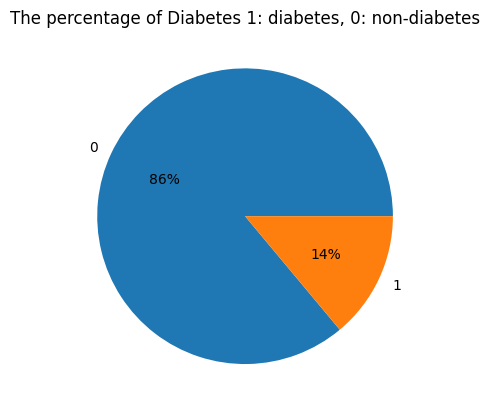

In [ ]:
#proportion of diabetes in the dataset
count_data = df["Diabetes"].value_counts()
labels_data = df["Diabetes"].value_counts().index

plt.pie(count_data, labels=labels_data, autopct='%.0f%%')
plt.title("The percentage of Diabetes 1: diabetes, 0: non-diabetes")

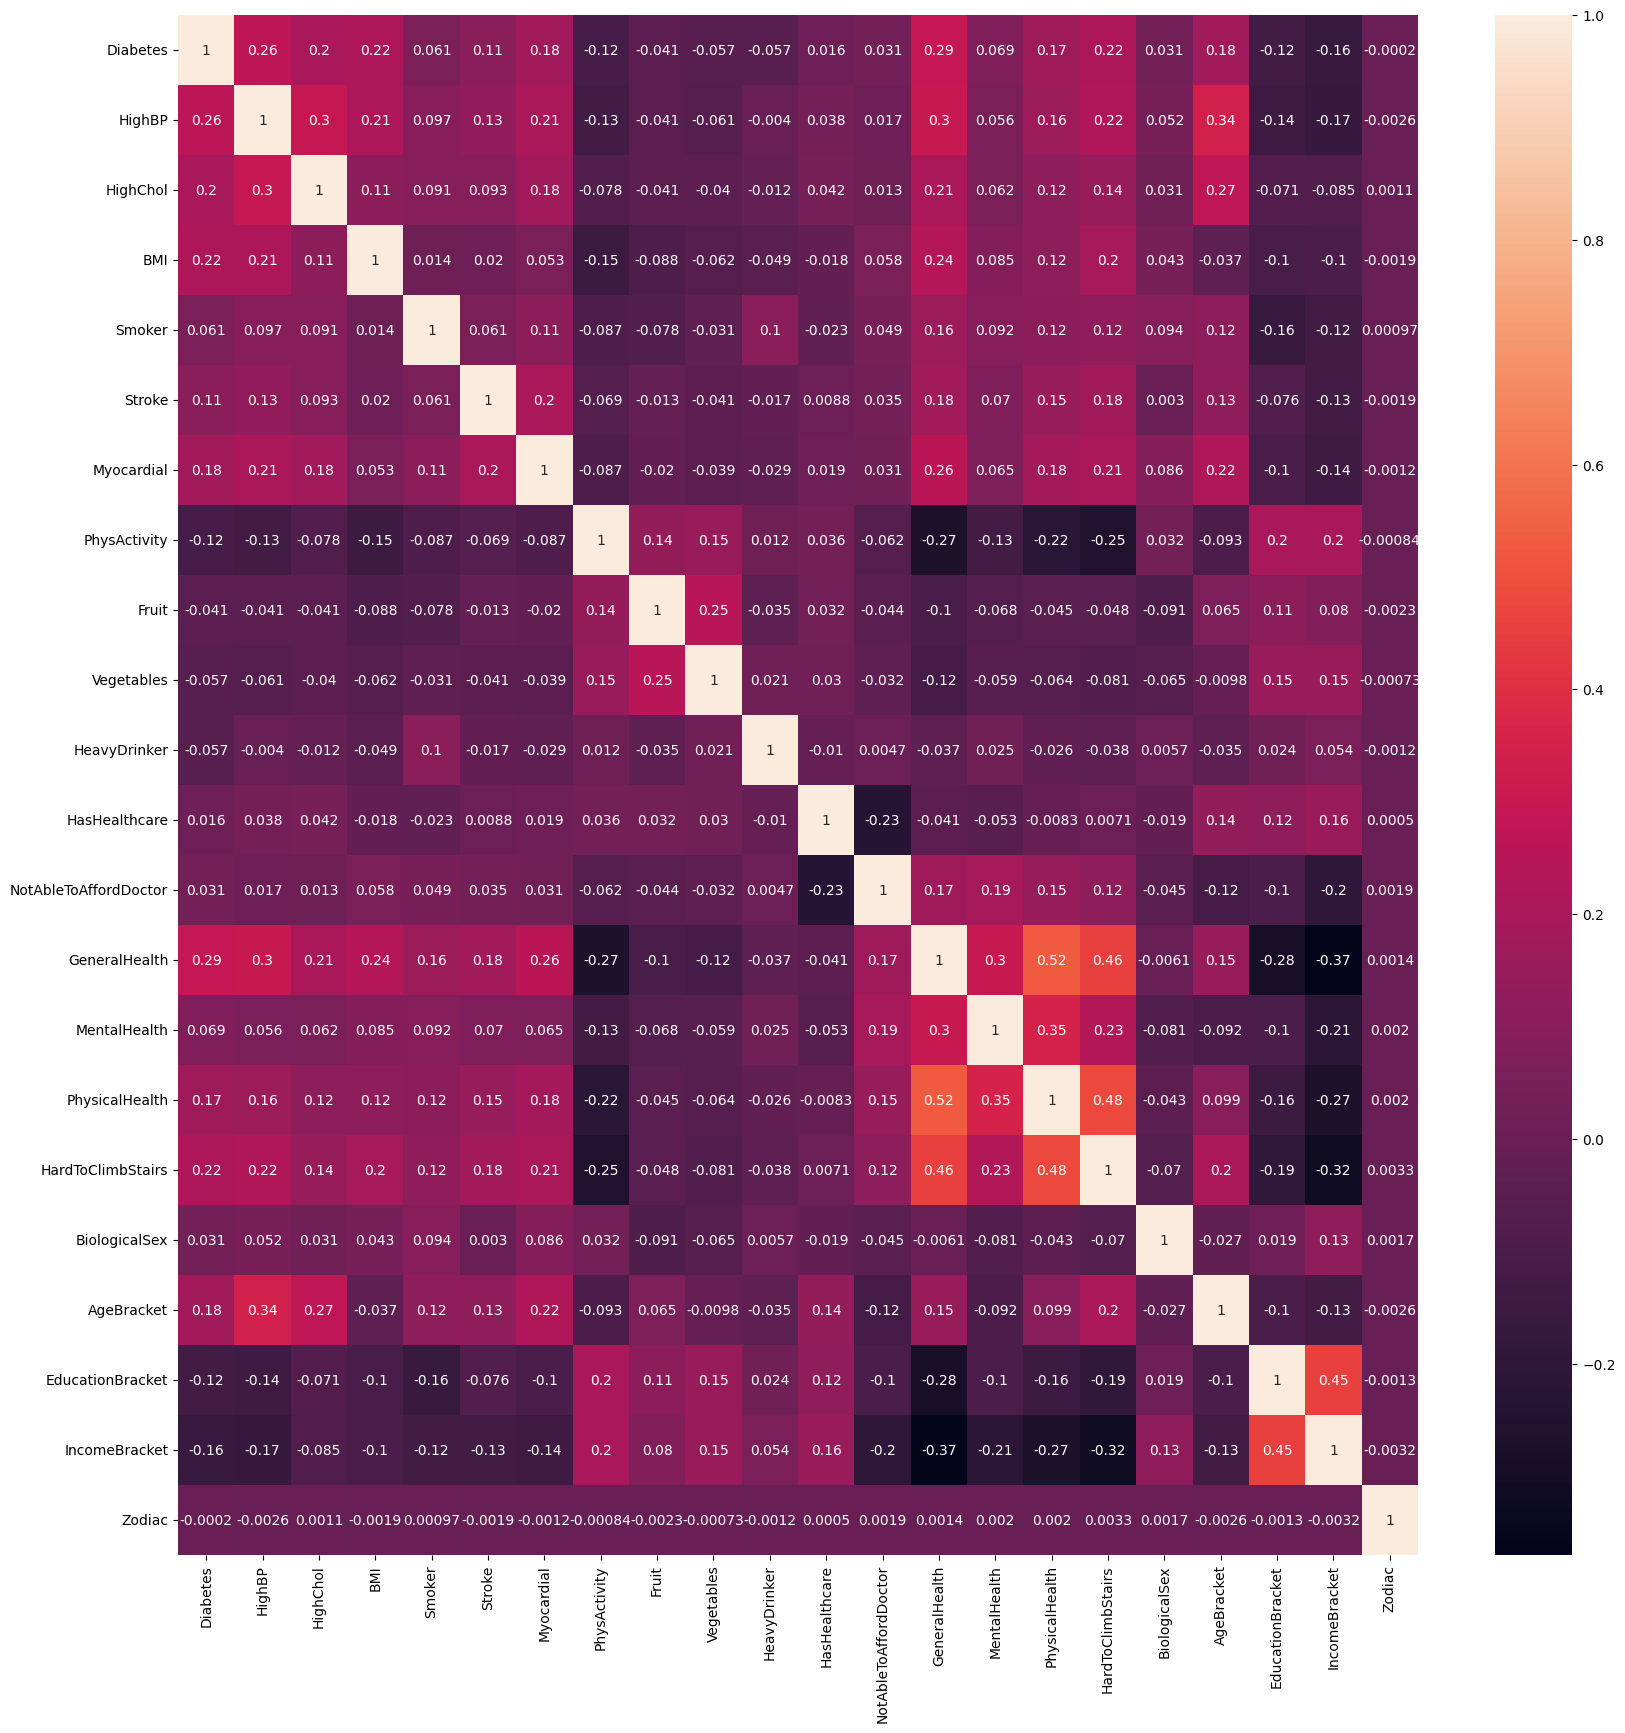

In [ ]:
#correlation matrix presented as heatmap
plt.figure(figsize = (20,20))
heatmap = sns.heatmap(df.corr(), annot=True)
plt.show()

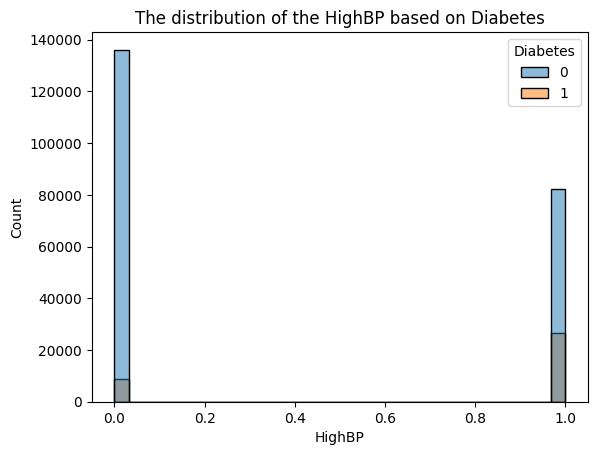

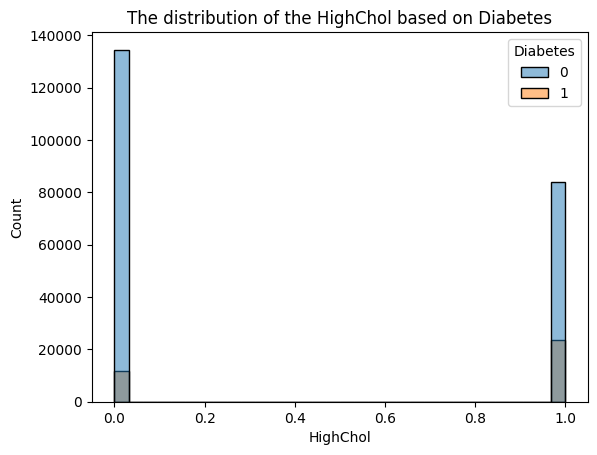

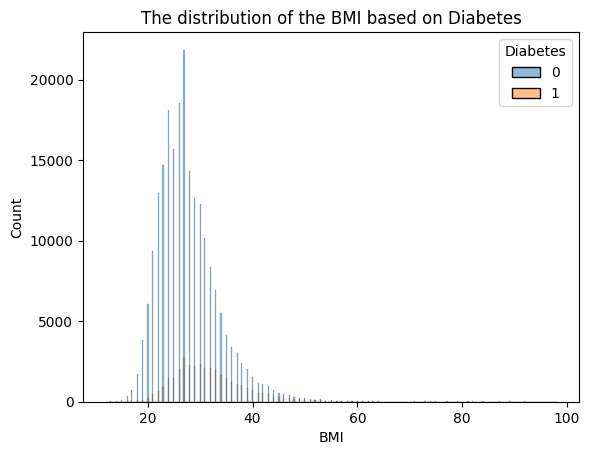

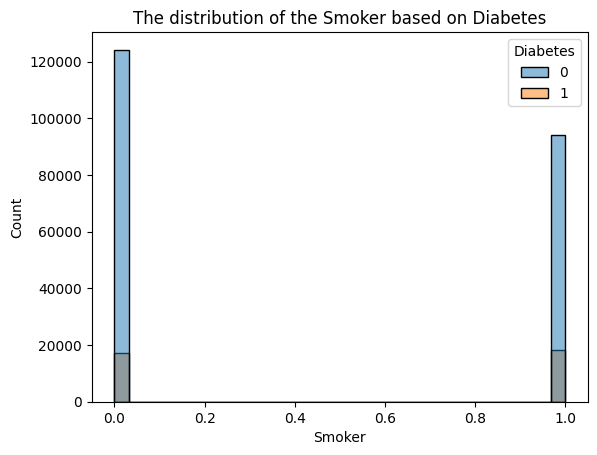

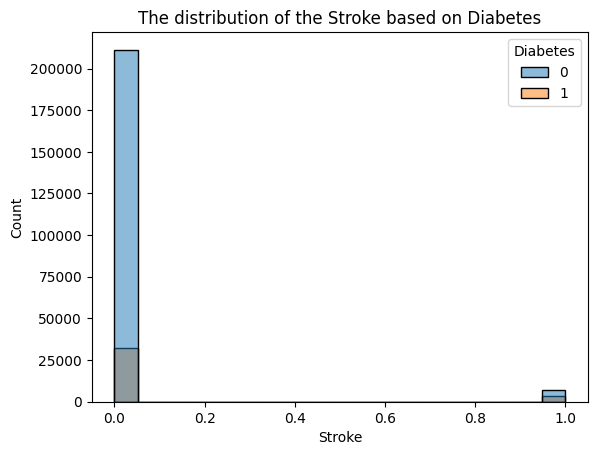

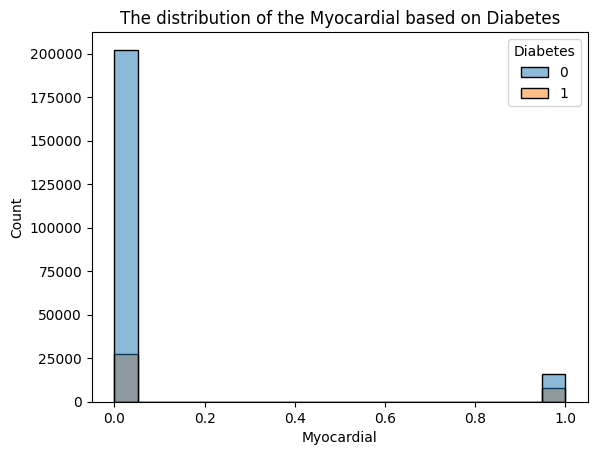

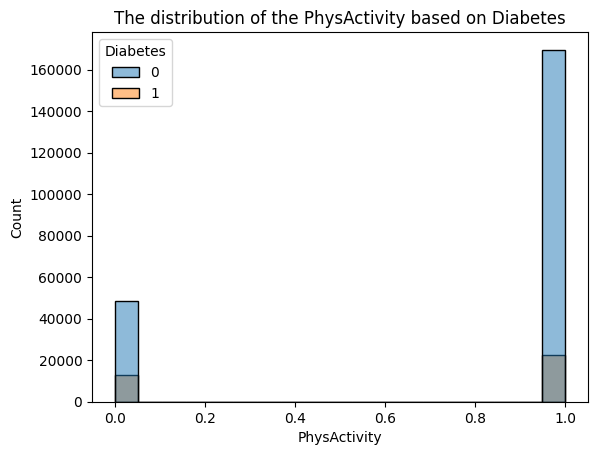

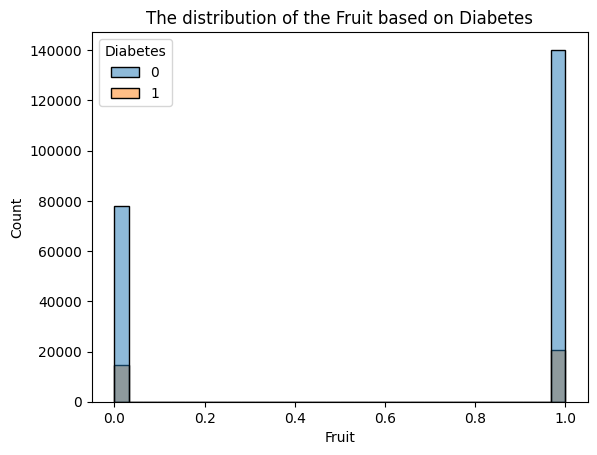

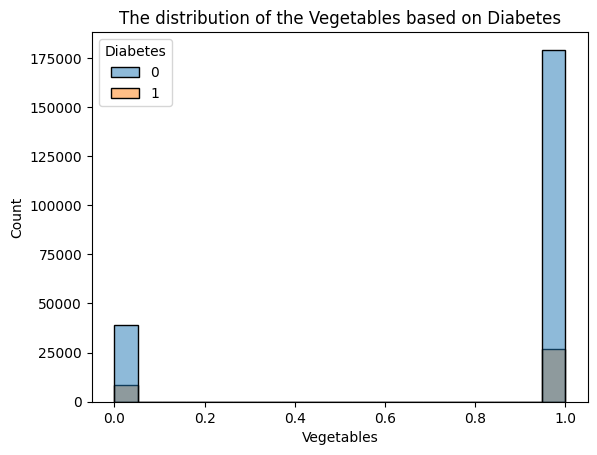

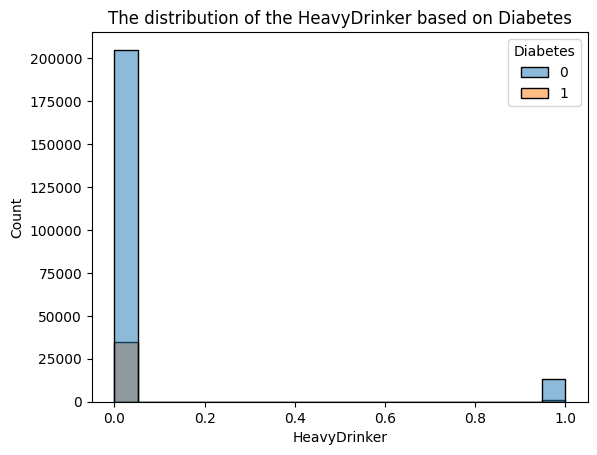

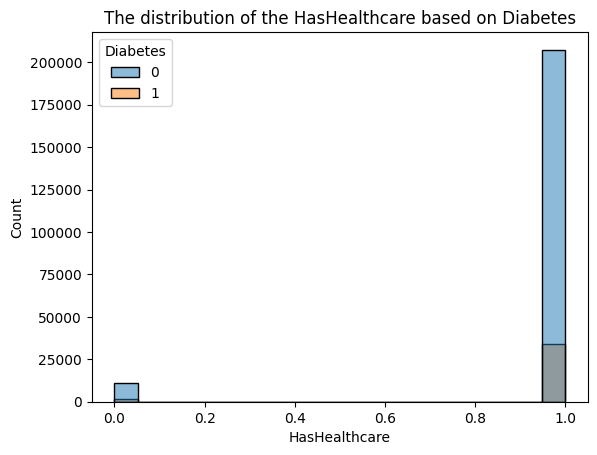

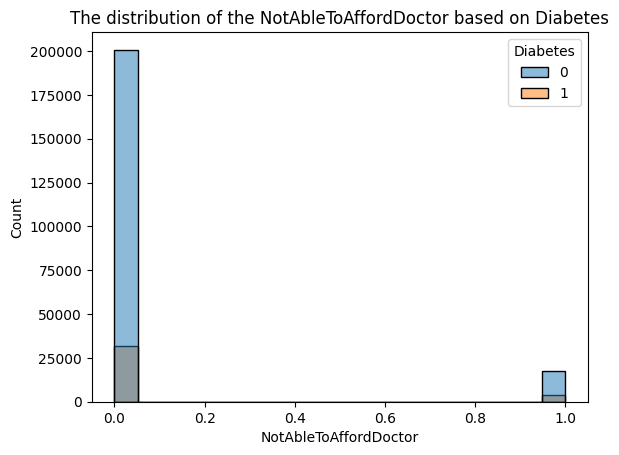

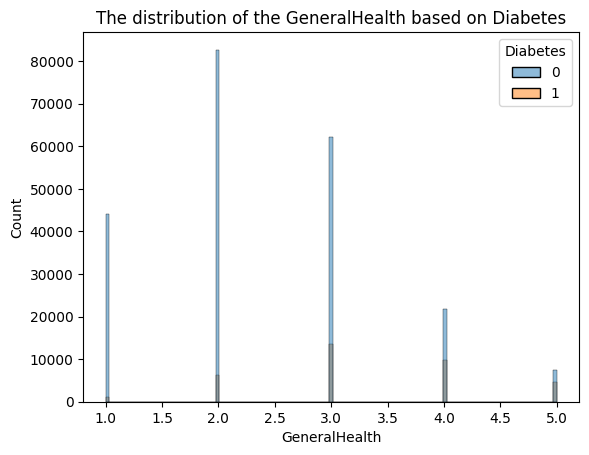

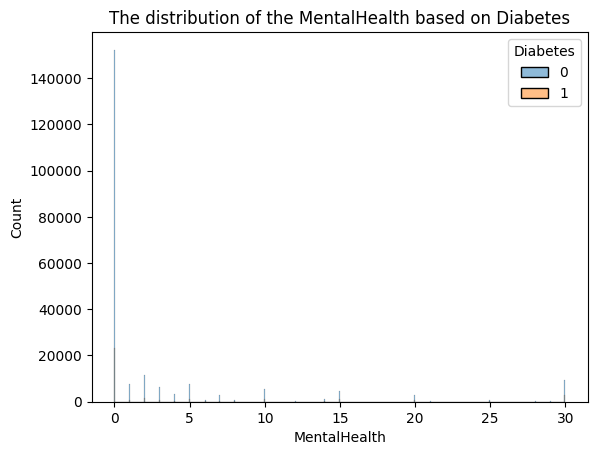

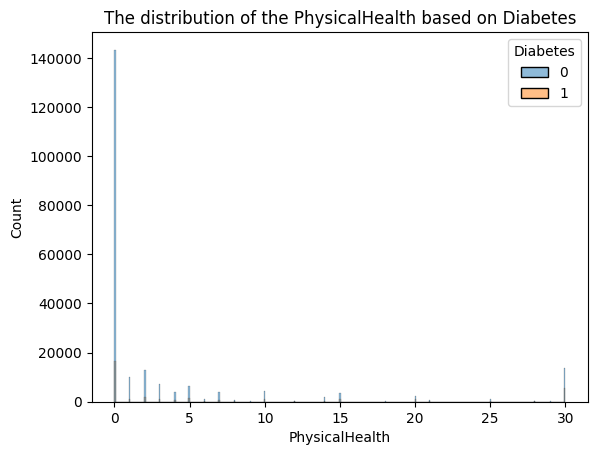

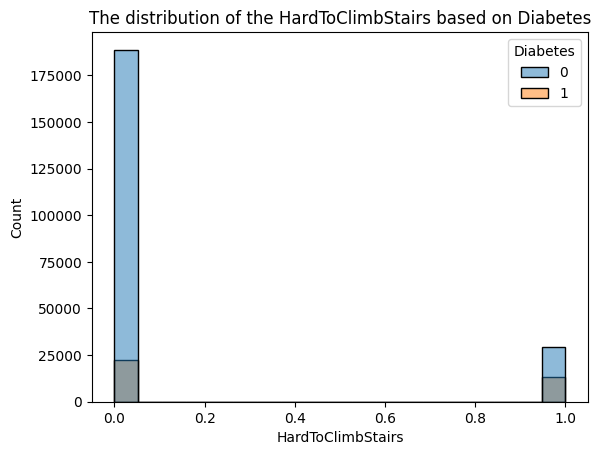

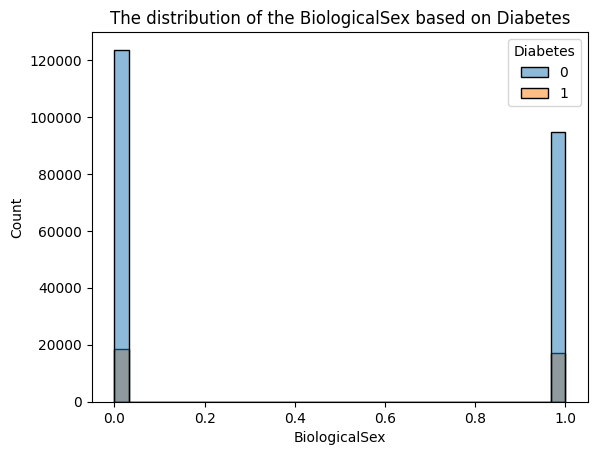

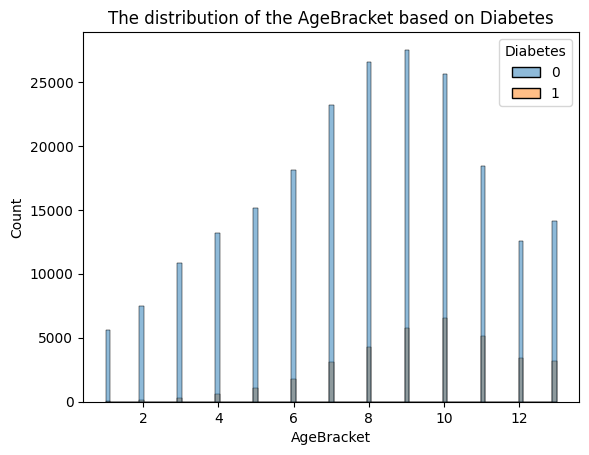

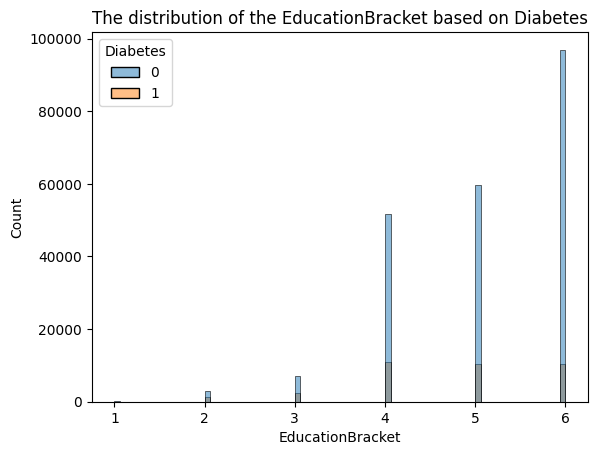

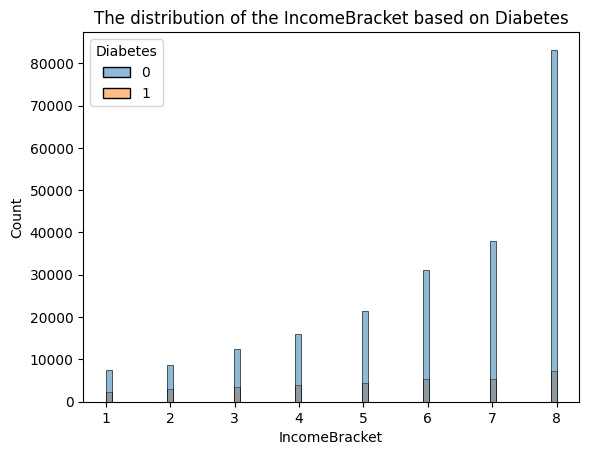

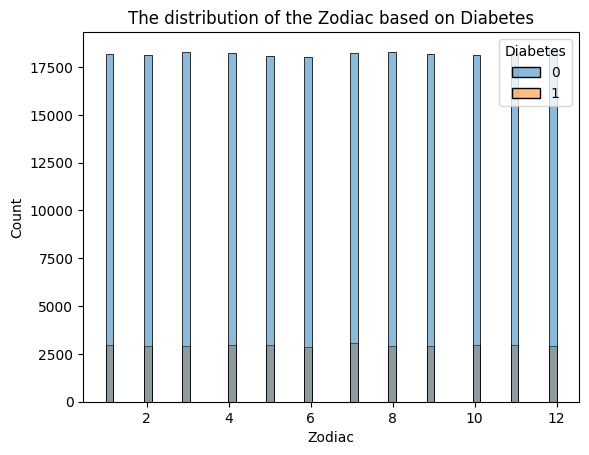

In [ ]:
#distribution of each variable
for i in df.columns[1:]:
  sns.histplot(data = df, x = i, hue = 'Diabetes')
  plt.title('The distribution of the {} based on Diabetes'.format(i))
  plt.show()

## Data Preprocessing

In [ ]:
# Split the data.
train_data, val_data = model_selection.train_test_split(df, test_size = 0.2, random_state=12345) # 0.2 is 20% validation data.

# Split the features from the class labels.
X_train = train_data.drop('Diabetes', axis = 1) # We drop the target from the features.  
X_val  = val_data.drop('Diabetes', axis = 1)  # Note that this does not operate inplace.
 
y_train = train_data['Diabetes']
y_val  = val_data['Diabetes']

In [ ]:
#convert traning and testing data to tensor
X_train_tensor = torch.tensor(np.array(X_train),dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train),dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(np.array(X_val),dtype=torch.float32)
y_val_tensor = torch.tensor(np.array(y_val),dtype=torch.float32).unsqueeze(1)

# Create a DataLoader for the training data
train_data_tensor = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 32

# 1. Build and train a Perceptron (one input layer, one output layer, no hidden layers and no activation functions) to classify diabetes from the rest of the dataset. What is the AUC of this model? 

In [ ]:
#1 perceptron
clf = Perceptron(tol=1e-3, random_state=12345)
### This is equivalent to SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
clf.fit(X_train,y_train)

Perceptron(random_state=12345)

In [ ]:
clf.score(X_val, y_val)

0.859271523178808

In [ ]:
#testing accuracy
pred = clf.predict(X_val)

# See the percentage of examples that are correctly classified.
accuracy = metrics.accuracy_score(y_val, pred) 
print("Accuracy = {:0.1f}%".format(accuracy * 100))

# The matrix of predictions and true values for each class.
conf_matrix = metrics.confusion_matrix(y_val, pred)
print("Confusion matrix = ")
print(conf_matrix)

Accuracy = 85.9%
Confusion matrix = 
[[43437   164]
 [ 6976   159]]


AUC Score: 0.78


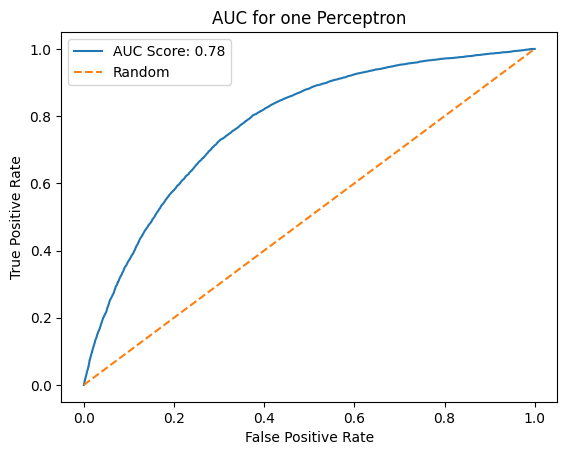

In [ ]:
#get probability distribution and auc score
y_pred_proba_perc = clf.decision_function(X_val)
auc_score = roc_auc_score(y_val, y_pred_proba_perc)
print(f"AUC Score: {auc_score:.2f}")

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_perc)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"AUC Score: {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title('AUC for one Perceptron')
plt.show()

Using sklearn package, we build a Perceptron model and achieved accuracy of 85.9%. However, looking at the confusion matrix, we see that most of the data are predicted positive: there is a huge number of false positives. Considering the imbalanced distribution of patients with diabetes, the performance is not as good as the accuracy metric indicates. Nevertheless, the AUC score of our Perceptron model is 0.78.

# 2. Build and train a feedforward neural network with at least one hidden layer to classify diabetes from the rest of the dataset. Make sure to try different numbers of hidden layers and different activation functions (at a minimum reLU and sigmoid). Doing so: How does AUC vary as a function of the number of hidden layers and is it dependent on the kind of activation function used (make sure to include “no activation function” in your comparison). How does this network perform relative to the Perceptron?

In [ ]:
#this is the hyperparameters we will use for the assignment
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
input_size = X_train_tensor.shape[1]  # dimensions
output_size = 1  # num_classes
hidden_size = 100  # num_hidden_units
epochs = 100 #number of epochs to iterate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#setting hyperparameters for optimizer and criterion
learning_rate = 1e-1
lambda_l2 = 1e-3

In [ ]:
def train(model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs):
  # Training
  for t in range(epochs):
    # Forward pass over the model to get the logits
    y_pred = model(X_train_tensor)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y_train_tensor)
    if t == epochs-1:
      print("[EPOCH]: %i, [LOSS]: %.6f" % (t, loss.item()))
      
    # reset (zero) the gradients before running the backward pass over the model
    optimizer.zero_grad()

    # Backward pass to compute the gradient of loss w.r.t our learnable params (weights and biases)
    loss.backward()
    
    # Update params
    optimizer.step()

In [ ]:
def evaluate(model, X_val_tensor):
#stop gradient descent for the model
  with torch.no_grad():
    #get predicted output
    y_pred_tensor = model(X_val_tensor)
    #classification using 0.5 as threshold
    predicted = (y_pred_tensor > 0.5).float()
  #get 
  auc_score = roc_auc_score(y_val_tensor.detach().numpy(), y_pred_tensor.detach().numpy())
  accuracy = accuracy_score(y_val_tensor.detach().numpy(), predicted.detach().numpy())

  return auc_score,accuracy

## 1 hidden layer

### ReLU activation function

In [ ]:
#one hidden layer nn with relu activation
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.BCEWithLogitsLoss()

#tranining model
train(model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs)
#evaluation: accuracy and auc score
auc,acc = evaluate(model, X_val_tensor)
print('Activation Function: ReLU, Accuracy: {},  AUC: {}'.format(acc, auc))

[EPOCH]: 99, [LOSS]: 0.393552
Activation Function: ReLU, Accuracy: 0.8593700725323242,  AUC: 0.7250109874652167


### Sigmiod activation function

In [ ]:
#one hidden layer nn with Sigmoid activation
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.BCEWithLogitsLoss()

#tranining model
train(model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs)
#evaluation: accuracy and auc score
auc,acc = evaluate(model, X_val_tensor)
print('Activation Function: Sigmoid, Accuracy: {},  AUC: {}'.format(acc, auc))

[EPOCH]: 99, [LOSS]: 0.375511
Activation Function: Sigmoid, Accuracy: 0.8593700725323242,  AUC: 0.7331000280671575


We see that feedforward neural network with 1 hidden layer, two models with different activation functions perform comparably. 1 hidden layer feedforward network with ReLU activation function achieved the same accuracy (0.859) as the network with Sigmoid activation function, but ReLU activation function resulted in bigger loss (0.3935 as to 0.3755 with Sigmoid) and also smaller AUC (0.7250 as the 0.7331 with Sigmoid).

## 2 hidden layers

### ReLU activation function

In [ ]:
#2 hidden layers nn with relu activation
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.BCEWithLogitsLoss()

#tranining model
train(model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs)
#evaluation: accuracy and auc score
auc,acc = evaluate(model, X_val_tensor)
print('Activation Function: ReLU, Accuracy: {},  AUC: {}'.format(acc, auc))

[EPOCH]: 99, [LOSS]: 0.363580
Activation Function: ReLU, Accuracy: 0.8593700725323242,  AUC: 0.7400662714720464


### Sigmiod activation function

In [ ]:
#2 hidden layers nn with Sigmoid activation
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.BCEWithLogitsLoss()

#tranining model
train(model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs)
#evaluation: accuracy and auc score
auc,acc = evaluate(model, X_val_tensor)
print('Activation Function: Sigmoid, Accuracy: {},  AUC: {}'.format(acc, auc))

[EPOCH]: 99, [LOSS]: 0.400793
Activation Function: Sigmoid, Accuracy: 0.8593700725323242,  AUC: 0.7003395446190095


### No activation function

In [ ]:
#2 hidden layers nn with no activation
model_no = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Linear(hidden_size, hidden_size),
    nn.Linear(hidden_size, output_size)
)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_no.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

#tranining model
train(model_no, criterion, optimizer, X_train_tensor, y_train_tensor, epochs)

[EPOCH]: 99, [LOSS]: 0.378115


In [ ]:
#evaluation: accuracy and auc score
model_no.eval()

with torch.no_grad():   # turn off gradient calculation during evaluation
  y_pred = model_no(X_val_tensor)
  y_pre_proba = (y_pred > 0.5).float()

  auc_score = roc_auc_score(y_val_tensor.detach().numpy(), y_pred.detach().numpy())
  accuracy = accuracy_score(y_val_tensor.detach().numpy(), y_pre_proba.detach().numpy())

print("Accuracy: {:.4f}, AUC Score: {:.4f}".format(accuracy, auc_score))

Accuracy: 0.8589, AUC Score: 0.7361


With 2 hidden layers feedforward neural network, the results are similar to 1 hidden layer feedforward neural network. 2 hidden layers feedforward network with ReLU activation function achieved the same accuracy (0.859) as the network with Sigmoid activation function. ReLU activation function resulted in smaller loss (0.3636 as to 0.4008 with Sigmoid) and also bigger AUC (0.7401 as the 0.7003 with Sigmoid). Thus we can see that with more hidden layers, ReLU activation function might perform better than Sigmoid activation function.

We also included 2 hidden layers feedforward neural network with no activation function. By the architect of feedforward neural network, if there is no activation function, the model would perform just like a linear regression. Looking at the performance of 2 hidden layers feedforward neural network with no activation function, we see that the accuracy is slightly better than both networks with ReLU and Sigmoid activation functions. The AUC score (0.7361) of network with no activation function is better than the network with Sigmoid activation function (0.7003) but slightly less than the network with ReLU activation function (0.7401).

# 3. Build and train a “deep” network (at least 2 hidden layers) to classify diabetes from the rest of the dataset. Given the nature of this dataset, is there a benefit of using a CNN or RNN for the classification? 

In [ ]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.BCEWithLogitsLoss()

train(model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs)
auc,acc = evaluate(model, X_val_tensor)
print('Activation Function: ReLU, Accuracy: {},  AUC: {}'.format(acc, auc))

[EPOCH]: 99, [LOSS]: 0.381553
Activation Function: ReLU, Accuracy: 0.8593700725323242,  AUC: 0.6836816296187315


Based on the performance results from Q2, we adopted ReLU activation function for our deep network. We constructed a 3 hidden layer feedforward neural network. The resulting accuracy is 0.85937 with loss of 0.3816 and an AUC score of 0.6837. The result indicates that while the accuracy does not change, the loss and auc score indeed decrease.

Given the nature of this dataset, there is no significant benefit for using either CNN or RNN for the classification task. Fist, there is in theory (if there is no order of respondents based on certain condition) no spacial concept among the datapoints, and thus there would be no correlation among neighboring data (unlike neighboring pixels in an image). Thus it would not be very suitable to use CNN. Second, there is also no temporal concept in the dataset (unlike order of words in a sentence), and thus adopting RNN would also not be suitable. If there needs to be a choice made, we might utilize CNN and see if there is any correlation among neighboring data.

# 4. Build and train a feedforward neural network with one hidden layer to predict BMI from the rest of the dataset. Use RMSE to assess the accuracy of your model. Does the RMSE depend on the activation function used? 

In [ ]:
# Split the features from the class labels.
X4_train = train_data.drop('BMI', axis = 1) # We drop the target from the features.  
X4_val  = val_data.drop('BMI', axis = 1)  # Note that this does not operate inplace.
 
y4_train = train_data['BMI']
y4_val  = val_data['BMI']

In [ ]:
X4_train_tensor = torch.tensor(np.array(X4_train),dtype=torch.float32)
y4_train_tensor = torch.tensor(np.array(y4_train),dtype=torch.float32).unsqueeze(1)
X4_val_tensor = torch.tensor(np.array(X4_val),dtype=torch.float32)
y4_val_tensor = torch.tensor(np.array(y4_val),dtype=torch.float32).unsqueeze(1)

# Create a DataLoader for the training data
train_data4_tensor = TensorDataset(X4_train_tensor, y4_train_tensor)
batch_size = 32

Text(0.5, 1.0, 'The percentage of BMI')

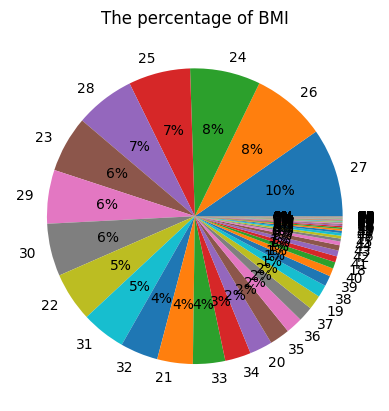

In [ ]:
#proportion of diabetes in the dataset
count_data = df["BMI"].value_counts()
labels_data = df["BMI"].value_counts().index

plt.pie(count_data, labels=labels_data, autopct='%.0f%%')
plt.title("The percentage of BMI")

In [ ]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
input_size = X4_train_tensor.shape[1]  # dimensions
output_size = 1  # num_classes
hidden_size = 100  # num_hidden_units
epochs = 100

In [ ]:
learning_rate = 1e-1
lambda_l2 = 1e-3

In [ ]:
def evaluate_rmse(model, X_val_tensor):
  with torch.no_grad():
    y_pred_tensor = model(X_val_tensor)
#get rmse for the testing data
  rmse = np.sqrt(mean_squared_error(y4_val_tensor.detach().numpy(), y_pred_tensor.detach().numpy()))

  return rmse

### ReLU activation function

In [ ]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = nn.MSELoss()   # Mean Squared Error loss

train(model, criterion, optimizer, X4_train_tensor, y4_train_tensor, epochs)


[EPOCH]: 99, [LOSS]: 43.198971


In [ ]:
rmse = evaluate_rmse(model, X4_val_tensor)
print('Activation Function: ReLU, RMSE: {}'.format(rmse))

Activation Function: ReLU, RMSE: 6.751518726348877


### Sigmoid activation function

In [ ]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = nn.MSELoss()   # Mean Squared Error loss

train(model, criterion, optimizer, X4_train_tensor, y4_train_tensor, epochs)

[EPOCH]: 99, [LOSS]: 43.197952


In [ ]:
rmse = evaluate_rmse(model, X4_val_tensor)
print('Activation Function: Sigmoid, RMSE: {}'.format(rmse))

Activation Function: Sigmoid, RMSE: 6.751293659210205


For this question, the data is modified so that attribute BMI becomes our label and test train split is reworked. We used feedforward neural network with 1 hidden layer, and testing both the ReLU and Sigmoid activation function. With the same building block to trained the neural networks with traning data, we only changed the evaluation metrics from accuracy and auc score to RMSE. The results of two networks exhibit almost the same RMSE, and we can conclude that with the same hyperparameter, the RMSE does not depend on activation functions used in the neural network. 

# 5. Build and train a neural network of your choice to predict BMI from the rest of your dataset. How low can you get RMSE and what design choices does RMSE seem to depend on?

In [ ]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = nn.MSELoss()   # Mean Squared Error loss

train(model, criterion, optimizer, X4_train_tensor, y4_train_tensor, epochs)

[EPOCH]: 99, [LOSS]: 43.198982


In [ ]:
rmse = evaluate_rmse(model, X4_val_tensor)
print('Activation Function: Sigmoid, RMSE: {}'.format(rmse))

Activation Function: Sigmoid, RMSE: 6.751518249511719


In [ ]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = nn.MSELoss()   # Mean Squared Error loss

train(model, criterion, optimizer, X4_train_tensor, y4_train_tensor, 50)

[EPOCH]: 49, [LOSS]: 43.199020


In [ ]:
rmse = evaluate_rmse(model, X4_val_tensor)
print('Activation Function: Sigmoid, 50 epoch, RMSE: {}'.format(rmse))

Activation Function: Sigmoid, 50 epoch, RMSE: 6.751535415649414


In [ ]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = nn.MSELoss()   # Mean Squared Error loss

train(model, criterion, optimizer, X4_train_tensor, y4_train_tensor, epochs)

[EPOCH]: 99, [LOSS]: 42.379414


In [ ]:
rmse = evaluate_rmse(model, X4_val_tensor)
print('Activation Function: ReLU, Adam optimizer, 50 epoch, RMSE: {}'.format(rmse))

Activation Function: ReLU, Adam optimizer, 50 epoch, RMSE: 6.6896562576293945


In [ ]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = nn.MSELoss()   # Mean Squared Error loss

train(model, criterion, optimizer, X4_train_tensor, y4_train_tensor, epochs)

[EPOCH]: 99, [LOSS]: 40.438385


In [ ]:
rmse = evaluate_rmse(model, X4_val_tensor)
print('Activation Function: ReLU, Adam optimizer, RMSE: {}'.format(rmse))

Activation Function: ReLU, Adam optimizer, RMSE: 6.614922523498535


For this question, we first implemented a 2 hidden layers feedforward neural network with Sigmoid function as activation function, keeping rest of the hyperparameters the same, as our baseline model for evaluating performance change. Our baseline model has a RMSE of 6.7515 and loss of 43.20. then we decrease the number of epochs for training the model, and we see that indeed loss slightly increased, but there is almost no change in RMSE. 

Nect step we changed our optimizer from Stochastic Gradient Descent (SGD) to Adam, and there is a discernible change in our metrics. The loss decreased to 42.38, and RMSE decreased to 6.69. Keeping the optimizer as Adam optimizer, we changed the activation function to ReLU. We see that the loss is slightly higher (40.44), but RMSE decreases to 6.61. 

In conlcusion, since we have already enough number of iterations to train the model (loss already converging), changing epochs from 100 to 50 does not really change the performance. However, changing optimizer from SDG to Adam indeed help the model perform better. ReLU activation function only slightly increases auc of the model. 

# Extra Credits:

## A) Are there any predictors/features that have effectively no impact on the accuracy of these models? If so, please list them and comment briefly on your findings.

In [ ]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)
# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.BCEWithLogitsLoss()

train(model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs)
auc,acc = evaluate(model, X_val_tensor)
print('Activation Function: ReLU, Accuracy: {},  AUC: {}'.format(acc, auc))

[EPOCH]: 99, [LOSS]: 0.367265
Activation Function: ReLU, Accuracy: 0.8593700725323242,  AUC: 0.7372924172691885


In [ ]:
model = nn.Sequential(
    nn.Linear(input_size-1, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

#dropping every predictor variable and see which drops the performance the most
for i in X_train.columns:
  X_train_drop = X_train.drop([i], axis=1)
  X_val_drop = X_val.drop([i], axis=1)

  X_train_drop_tensor = torch.tensor(np.array(X_train_drop),dtype=torch.float32)
  X_val_drop_tensor = torch.tensor(np.array(X_val_drop),dtype=torch.float32)

  train(model, criterion, optimizer, X_train_drop_tensor, y_train_tensor, 20)

  auc,acc = evaluate(model, X_val_drop_tensor)

  print("Activation Function: ReLU, Dropping predictor {}:".format(i))
  print('Accuracy: {},  AUC: {}'.format(acc, auc))
  print()

[EPOCH]: 19, [LOSS]: 0.404549
Activation Function: ReLU, Dropping predictor HighBP:
Accuracy: 0.8593700725323242,  AUC: 0.6351693408470747

[EPOCH]: 19, [LOSS]: 0.385586
Activation Function: ReLU, Dropping predictor HighChol:
Accuracy: 0.8593700725323242,  AUC: 0.6876305177869

[EPOCH]: 19, [LOSS]: 0.370993
Activation Function: ReLU, Dropping predictor BMI:
Accuracy: 0.8593700725323242,  AUC: 0.7177527012931353

[EPOCH]: 19, [LOSS]: 0.368197
Activation Function: ReLU, Dropping predictor Smoker:
Accuracy: 0.8593700725323242,  AUC: 0.7144657210130978

[EPOCH]: 19, [LOSS]: 0.356480
Activation Function: ReLU, Dropping predictor Stroke:
Accuracy: 0.8593700725323242,  AUC: 0.7424813617311099

[EPOCH]: 19, [LOSS]: 0.361483
Activation Function: ReLU, Dropping predictor Myocardial:
Accuracy: 0.8593700725323242,  AUC: 0.7497974119551047

[EPOCH]: 19, [LOSS]: 0.361634
Activation Function: ReLU, Dropping predictor PhysActivity:
Accuracy: 0.8593897824030274,  AUC: 0.7506494927957827

[EPOCH]: 19, [

In [ ]:
model = nn.Sequential(
    nn.Linear(input_size-1, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = nn.MSELoss()   # Mean Squared Error loss

#dropping every predictor variable and see which drops the performance the most
for i in X4_train.columns:
  X4_train_drop = X4_train.drop([i], axis=1)
  X4_val_drop = X4_val.drop([i], axis=1)

  X4_train_drop_tensor = torch.tensor(np.array(X4_train_drop),dtype=torch.float32)
  X4_val_drop_tensor = torch.tensor(np.array(X4_val_drop),dtype=torch.float32)

  train(model, criterion, optimizer, X4_train_drop_tensor, y4_train_tensor, 10)
  rmse = evaluate_rmse(model, X4_val_drop_tensor)

  print("Activation Function: ReLU, Dropping predictor {}:".format(i))
  print('RMSE: {}'.format(rmse))
  print()

[EPOCH]: 9, [LOSS]: 179.354477
Activation Function: ReLU, Dropping predictor Diabetes:
RMSE: 9.681832313537598

[EPOCH]: 9, [LOSS]: 120.276932
Activation Function: ReLU, Dropping predictor HighBP:
RMSE: 10.443985939025879

[EPOCH]: 9, [LOSS]: 59.839115
Activation Function: ReLU, Dropping predictor HighChol:
RMSE: 8.313448905944824

[EPOCH]: 9, [LOSS]: 57.469971
Activation Function: ReLU, Dropping predictor Smoker:
RMSE: 7.600593566894531

[EPOCH]: 9, [LOSS]: 54.069664
Activation Function: ReLU, Dropping predictor Stroke:
RMSE: 7.424957752227783

[EPOCH]: 9, [LOSS]: 50.504730
Activation Function: ReLU, Dropping predictor Myocardial:
RMSE: 7.256918907165527

[EPOCH]: 9, [LOSS]: 48.514969
Activation Function: ReLU, Dropping predictor PhysActivity:
RMSE: 7.142003059387207

[EPOCH]: 9, [LOSS]: 47.403381
Activation Function: ReLU, Dropping predictor Fruit:
RMSE: 7.069512367248535

[EPOCH]: 9, [LOSS]: 46.981503
Activation Function: ReLU, Dropping predictor Vegetables:
RMSE: 7.048320293426514


For this question, we used 1 hidden layer feedforward neural network with ReLU activation function. In determining the performance of each predictor variable, we adopt the same method used in the last assignment: we control for each predictor variable by dropping them, and see the performance drop for each variable dropped. 

We have our baseline (not dropping any predictor variable) accuracy at 0.85937 and an AUC score of 0.7373. From the results displayed, we see that accuracy for each predictor dropped only changes when PhysActivity, Fruit, and Vegetables, and the accuracy increases. Due to the large number of epochs, we conlcude with almost converged loss and accuracy, and thus there is not much change in accuracy.

## b) Write a summary statement on the overall pros and cons of using neural networks to learn from the same dataset as in the prior homework, relative to using classical methods (logistic regression, SVM, trees, forests, boosting methods). Any overall lessons?

Comparing to classification methods utilized in the last assignment, we see that neural networks takes its advantage in the learning complex patterns, and we see that the accuracy and auc score are generally higher for neural networks than models we implemented for the last assignment. But the downside is the high computational requirements, including longer time to train and also lack of interpretability in the intermediary steps. 

Overall, the lesson learned from this assignment is that neural network defenitely a powerful tool, but we should use it at discretion. 